(perc-lab)=
# Perceptron

```{tip}

*Practice makes perfect*
                             
```

## Supervised learning

In [1]:
import numpy as np

# showing imported graphics
from IPython.display import display, Image

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

import sys # system library
sys.path.append('./lib_nn') # my path (linux, Mac OS)

from neural import * # import my library packages

Invoking __init__.py for neural


We have shown in the previous chapters that even the simplest ANNs can carry out useful tasks (emulate logical networks or provide simple memory models). Generally, each ANN has

- some **architecture**, i.e. the number of layers, number of neurons in each layer, scheme of connections between the neurons (fully connected or not, feed forward, recurrent, ...),

- **weights (hyperparameters)**, with specific values, defining the network's functionality.

The prime practical question is how to set (for a given architecture) the weights such that a requested goal is realized, i.e., a given input yields a desired output. 
In the tasks discussed earlier, the weights could be constructed *a priori*, be it for the logical gates or for the memory models. However, for more involved applications we want to have an "easier" way of determining the weights. Actually, for complicated problems a "theoretical" determination of weights is not possible at all. This is the basic reason for inventing **learning algorithms**, which automatically adjust the weights with the help of a data sample. 

In this chapter we begin to explore such algorithms with the **supervised learning**, used for data classification.  

```{admonition} Supervised learning

In this strategy, the data must possess **labels** which a priori determine the correct category for each point. Think for example of pictures of animals (data) and their descriptions (cat,dog,...), which are the labels. 
The labeled data are split into a **training** sample and a **test** sample. 

The basic steps of supervised learning for a given ANN are following:

- Initialize somehow the weights, for instance randomly or to zero.

- Read subsequently the data points from the training sample and pass them throught your ANN. The obtained answer may differ from the correct one, determimed by the label, in which case the weights are adjusted according to a specific prescription (to be discussed later on). 

- Repeat, if needed, the previous step. Typically, the weights are changed less and less as the algorithm proceeds.

- Finish the training when a stopping criterion is reached (weights do not change much any more or the maximum number of iterations has been completed). 

- Test the trained ANN on the test sample.

If satisfied, you have a desired trained ANN performing a specific task, which can be used on new, unlabeled data. If not, you can split the sample in the training and the test parts in a different way and repeat the procedure from the beginning. Also, you may try to acquire more data, or change your network's architecture.

This he term "supervised" comes form the interpretation of the procedure where the labels are held by a "teacher", who thus knows which answers are correct and which are wrong, and who **supervises** the training process.
```

## Binary classifier

The simplest supervised learning algorithm 
is the [perceptron](https://en.wikipedia.org/wiki/Perceptron), invented in 1958 by Frank Rosenblatt. It can be used to 
construct **binary classifiers** for the data. *Binary* means that the network 
is used to assess if a data point has a particular feature, or not. 

```{Admonition} Remark

The term *perceptron* is also used for ANNs (without or with intermediate layers) consisting of the MCP neurons (cf. Fig. {numref}`ffnn-fig` and {numref}`MCP1-fig`), on which the perceptron algorithm is executed. 
```

### Sample with a known classification rule

To begin, we need some training data, which we will generate as random points in a square. Thus the coordinates of the point, $x_1$ and $x_2$, are taken in the range $[0,1]$. We define two categories: one for the points lying above the line $x_1=x_2$ (call them pink), and the other for the points lying below (blue). During the generation, we check whether $x_2 > x_1$ or not, and assign a **label** to each data point equal to, correspongigly, 1 or 0.

The function generating the described data point with a label is 

In [2]:
# returns random coordinates x1, x2 and 1 if x2>x1, 0 otherwise
def point():
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1):                     # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0


We generate a **training sample** of **npo**=300 labeled data points:

In [3]:
npo=300 # number of data points in the training sample

print('  x1         x2         label')       # header
samp=np.array([point() for _ in range(npo)]) # training sample, _ is dummy iterator
print(samp[:5, :])                           # first 5 data points

  x1         x2         label
[[0.19968208 0.34399239 1.        ]
 [0.11365587 0.21869436 1.        ]
 [0.10854327 0.43462234 1.        ]
 [0.80135246 0.69970322 0.        ]
 [0.41130912 0.80434883 1.        ]]


Not to print unnecessarily the very long table, we have used above for the first time the **ranges for array indices**. For example, 2:5 means from 2 to 4 (the last one is excluded!), :5  - from 0 to 4, 5: - from 5 to the end, and : - all the indices.

Graphically, our data are show in the figure below. We also plot the line $x_2=x_1$, which separates the blue and purple points. In this case the division is a priori possible (we know the rule) in an exact manner. 

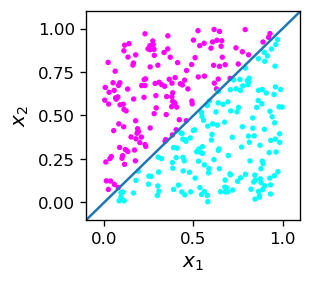

In [4]:
plt.figure(figsize=(2.3,2.3),dpi=120)                 
plt.xlim(-.1,1.1)                                  # axes limits
plt.ylim(-.1,1.1)
plt.scatter(samp[:,0],samp[:,1],c=samp[:,2],       # label determines the color
            s=5,cmap=mpl.cm.cool)                  # point size and color

plt.plot([-0.1, 1.1], [-0.1, 1.1])                 # separating line

plt.xlabel('$x_1$',fontsize=12)                    
plt.ylabel('$x_2$',fontsize=12);

```{admonition} Linearly separable sets

Two sets of points (e.g. blue and pink) on a plane which are possible to separate with a straigh line are called **linearly separable**. In three dimensions, the sets must be separable with a plane, in general in $n$ dimensions the sets must must be separable with a $n-1$ dimensional hyperplane.
```

Analitically, if the points in the $n$ dimensional space have coordinates $(x_1,x_2,\dots,x_n)$, one may chose the parameters $(w_0,w_1,\dots,w_n)$ in such a way that one set of points must satisfy the condition 


```{math}
:label: eq-linsep

w_0+x_1 w_1+x_2 w_2 + \dots x_n w_n > 0
```

and the other the opposite condition, with $>$ replaced with $\le$.

Now a crucial, albeit simple observation: the above inequality is precisely the condition implemented in the [MCP neuron](MCP-lab) (with the step activation function) in the convention of {numref}`MCP2-fig`! We may thus enforce condition {eq}`eq-linsep` with the **neuron** function from our **neural** library.

In our example we have for the pink points, by construction, 

$$
x_2>x_1 \to s=-x_1+x_2 >0
$$

from where, using  Eq. {eq}`eq-linsep`, we can immediately read out 

$$
w_0=0, \;\; w_1=-1, w_2=1.
$$

Thus the **neuron** function is used on a sample point p like this:

In [5]:
p=[0.6,0.8]      # sample point with x_2 > x_1
w=[0,-1,1]       # weights as given above

func.neuron(p,w) 

1

The neuron fired, so point p is pink.

```{admonition} Observation
:class: important

A single MCP neuron with properly chosen weights can be used as a binary classifier. 
```

### Sample with an unknown classification rule

At this point the reader may be a bit misled by the apparent triviality of the result. The confusion may stem from the fact that in our example we knew from the outset the rule defining the two classes of points ($x_2>x_1$, or opposite). However, in a general "real life" situation this is frequently not the case! Imagine that we encounter the (labeled) data **samp2** looking like this: 

In [6]:
def point2():
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1*0.52+0.25):               # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0

In [7]:
samp2=np.array([point2() for _ in range(npo)])              

In [8]:
print(samp2[:5])

[[0.52395167 0.07006229 0.        ]
 [0.46580068 0.17984878 0.        ]
 [0.88313537 0.80437289 1.        ]
 [0.22527853 0.93083163 1.        ]
 [0.67041055 0.97779144 1.        ]]


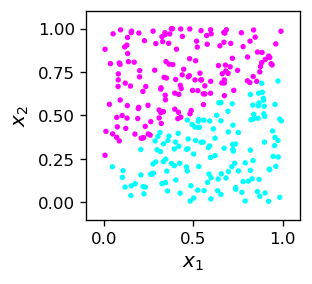

In [9]:
plt.figure(figsize=(2.3,2.3),dpi=120)                 
plt.xlim(-.1,1.1)                                  
plt.ylim(-.1,1.1)
plt.scatter(samp2[:,0],samp2[:,1],c=samp2[:,2],     
            s=5,cmap=mpl.cm.cool)                  

plt.xlabel('$x_1$',fontsize=12)                    
plt.ylabel('$x_2$',fontsize=12);

The situation is in some sense inverted now. We have abtained from somewhere the (linearly separable) data, and want to find the rule that defines the two classes. In other words, we need to draw a dividing line, which is equivalent to finding the weights of the MCP neuron of {numref}`MCP2-fig` that would carry out the classification.

## Perceptron algorithm

We could still try to figure out somehow the proper weights for the present example and find the dividing line, for instance with a ruler and pencil, but this is not the point. We wish to have a systematic algorithmic procedure that will effortlessly work for this one and any similar situation. The answer is the already mentioned [perceptron algorithm](https://en.wikipedia.org/wiki/Perceptron). 

Before presenting the algorithm, let us remark that the MCP neuron with some set of weigths $w_0, w_1, w_2$ will always yield some answer for a labeled data point, correct or wrong. For example

In [10]:
w=[-0.5,1,0]           # arbitrary choice of weights

print("label  answer") # header

for i in range(5): # look at first 5 points
    print(int(samp2[i,2]),"    ",func.neuron(samp2[i,:2],w)) 
    # samp2[i,2] is the label, samp2[i,:2] is [x_1,x_2]

label  answer
0      1
0      0
1      1
1      0
1      1


We can see that some answers are equal to the corresponding labels (correct), and some are different (wrong). The general idea now is to **use the wrong answers** to adjust cleverly, in small steps, the weights, such that after many iterations we get all the answers for the training sample correct!

```{admonition} Perceptron algorithm
:class: important

We iterate over the points of the training data sample.
If for a given point  the obtained result $y_o$ is equal to the true value $y_t$ (the label), i.e. the answer is  correct, we do nothing. However, if it is wrong, we change the weights a bit, such that the chance of getting the wrong answer decreses. The explicit recipe is as follows:

$w_i \to w_i  +  \varepsilon  (y_t - y_o)  x_i$,

where $ \varepsilon $ is a small number (called the **learning speed**) and $x_i$ are the coordinates of the input point, with $i=0,\dots,n$. 

Let us follow how it works. Suppose first that $ x_i> 0$. Then if the label $ y_t = 1 $ is greater than the obtained answer $ y_o = 0$, the weight $w_i$ is increased. Then $ w \cdot x $ also increases and $ y_o = f (w \cdot x) $ is more likely to acquire the correct value of 1 (we remember how the step function $f$ looks like). If, on the other hand, the label $ y_t = 0 $ is less than the obtained answer $ y_o = 1 $, then the weight $w_i$ is decreased, $ w \cdot x $ decreases, and $ y_o = f (w \cdot x) $ has a better chance of achieving the correct value of 0.

If $ x_i < 0 $ it is easy to use the same method to check that the recipe also works properly.

When the anwer is correct, $y_t=y_0$, then $ w_i \to w_i$, so nothing changes. We do not "spoil" the perceptron!

The above formula can be used many times for the same point from the traing sample. Next,  we loop over all the points of the sample, and the whole procedure can still be repeated in many rounds to obtain stable weights (not changing any more as we continue the procedure, or changing very slightly).

Typically, in such algorithms the learning speed $ \varepsilon $ is being decreased in successive rounds. This is technically very important, because too large steps can spoil the obtained solution.
```

The Python implementation of the perceptron algorithm for the 2-dimesional data is as follows:

In [11]:
w0=np.random.random()-0.5   # initialize weights randomly in the range [-0.5,0.5]
w1=np.random.random()-0.5
w2=np.random.random()-0.5

eps=.3  # initialize the learning speed 
   
for _ in range(20):        # loop over 20 rounds
    eps=0.9*eps            # in each round decrease the learning speed 
        
    for i in range(npo):   # loop over the points from the data sample
        
        for _ in range(5): # repeat 5 times for each points
            
            yo = func.neuron(samp2[i,:2],[w0,w1,w2]) # obtained answer
            
            w0=w0+eps*(samp2[i,2]-yo)   # weight update (perceptron formula)
            w1=w1+eps*(samp2[i,2]-yo)*samp2[i,0]
            w2=w2+eps*(samp2[i,2]-yo)*samp2[i,1]

print("  w0     w1     w2")        # header 
w_o=np.array([w0,w1,w2])           # obtained weights
print(np.round(w_o,3))             # result, rounded to 3 decimal places 


  w0     w1     w2
[-0.441 -0.88   1.74 ]


In [12]:
# for the separating line
def l2(w0,w1,w2):
    return [-.1,1.1],[-(w0-w1*0.1)/w2,-(w0+w1*1.1)/w2]

# corresponding separating line
lin=l2(w0,w1,w2)

It yields the result

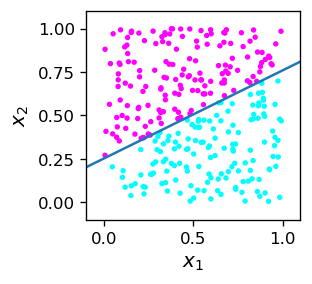

In [13]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(samp2[:,0],samp2[:,1],c=samp2[:,2],s=5,cmap=mpl.cm.cool)

plt.plot(lin[0],lin[1]) # plot the obtained separating line

plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12);

We can see that the algorithm works! All the pink points are above the line, and all the blue ones below. Let us emphasize that the dividing line, given by the equation 

$$ w_0+x_1 w_1 + x_2 w_2=0,$$

does not result from our a priori knowledge, but from the training of the MCP neuron which 
sets its weights. 


```{note}
One can prove that the perceptrom algorith converges if and only if the data are linearly seperable. 
```

We may now reveal our secret! The data of our sample were labeled at the time of creation with the rule 

$$ x_2>0.25+0.52 x_1 $$

which corresponds to weights $w_0^c=0.25$, $w_1^c=-0.52$, $w_2^c=1$. 

In [14]:
w_c=np.array([-0.25,-0.52,1]) # weights used for labeling the training sample
print(w_c)

[-0.25 -0.52  1.  ]


Note that this is not at all the same as the weights obtained from the training:

In [15]:
print(np.round(w_o,3))

[-0.441 -0.88   1.74 ]


The reason is twofold. First, note that the inequality condition {eq}`eq-linsep` is unchanged if we multiply both sides by a **positive** constant $c$. We may therefore scale all the weight by $c$, and the situation (the answers of the MCP neuron, the dividing line) remains exactly the same (we encounter here an **equivalece class** of weight scaled with a positive factor). 

For that reason, when we divide correspondingly the obtained weights by the weights used to label the sample, we get (almost) constant values: 

In [16]:
print(np.round(w_o/w_c,3))

[1.764 1.693 1.74 ]


The reason why the ratio values for $i=0,1,2$ are not exactly the same is that the sample has a finite number of points (here 300). Thus, there is gap between the two classes of points and there is some room for "jiggling" the separating line a bit. With more data points this mismatch effect would decrease (see the homework problem below). 

### Testing the classifier

Due to the limited size of the training sample and the "jiggling" effect desribed above, the classification result on a test sample is sometimes wrong. This always applies to the points near the dividing line, which is determined with accuracy depending on the multiplicity of the training sample. The code below carries out the check on a test sample. The test sample consists of labeled data generated randomly "on the flight" with the same function **point2** as for the training data used before: 

In [17]:
def point2():
    x1=np.random.random()          # random number from the range [0,1]
    x2=np.random.random()
    if(x2>x1*0.52+0.25):           # condition met
        return np.array([x1,x2,1]) # add label 1
    else:                          # not met
        return np.array([x1,x2,0]) # add label 0

The code for testing is as follows:

In [18]:
er= np.empty((0,3))  # initialize an empty 1 x 3 array to store misclassified points

ner=0                 # initial number of misclassified points
nt=3000               # number of test points

for _ in range(nt): # run for nt points
    ps=point2()       # a test point 
    if(func.neuron(ps[:2],[w0,w1,w2])!=ps[2]): # if wrong answers                                      
        er=np.append(er,[ps],axis=0)           # add the point to er
        ner+=1
        
print("number of misclassified points = ",ner," per ",nt," (", np.round(ner/nt*100,1),"% )")        

number of misclassified points =  12  per  3000  ( 0.4 % )


As we can see, a small number of test points are misclassified. All these points lie near the separating line. 

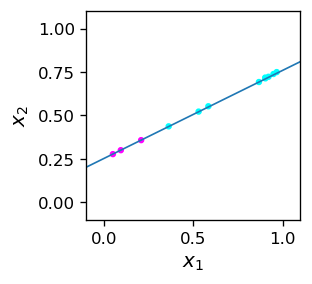

In [19]:
plt.figure(figsize=(2.3,2.3),dpi=120)
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(er[:,0],er[:,1],c=er[:,2],s=8,cmap=mpl.cm.cool)

plt.plot(lin[0],lin[1],linewidth=1) # plot the obtained separating line

plt.xlabel('$x_1$',fontsize=12)
plt.ylabel('$x_2$',fontsize=12);

```{admonition} Misclassification
:class: note

As it became clear, the reason for misclassification comes from the fact that the training sample does not determine the separating line precisely, but with some uncertainty, as there is a gap between the points of the training smaple. For a better result, the training points would have to be "denser" in the vicinity of the separation line, or the training sample would have to be larger. 
```

```{admonition} Exercises
:class: warning

- Play with the lecture code and see how the percentage of misclassified points decreases with the increasing size of the training sample.
- As the perceptron algorithm converges, at some point the weights stop to change. Improve the lecture code by implementing stopping when the weights do not change when passing to the next round. 
- Generalize the above classifier to points in 3-dimensional space.
```